In [3]:
import numpy as np
import scipy.io
import os
from tensorflow.keras import layers, models
import tensorflow as tf

# Define the TCN block
class TCNBlock(layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rate, **kwargs):
        super(TCNBlock, self).__init__(**kwargs)
        self.conv1d = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')
        self.batch_norm = layers.BatchNormalization()
        self.activation = layers.ReLU()
        self.dropout = layers.Dropout(0.2)

    def call(self, inputs, training=False):
        x = self.conv1d(inputs)
        x = self.batch_norm(x, training=training)
        x = self.activation(x)
        return self.dropout(x, training=training)

# Function to load EEG data and labels
def load_eeg_data(data_dir):
    eeg_data = []
    labels = []
    
    # Loop through all files in the directory
    for file_name in os.listdir(data_dir):
        if file_name.endswith('.mat'):
            # Load the .mat file
            file_path = os.path.join(data_dir, file_name)
            mat_data = scipy.io.loadmat(file_path)
            
            # Extract the 'data' variable (32xN matrix)
            data = mat_data['data']
            
            # Truncate or pad data to ensure consistent time steps (15470)
            if data.shape[1] > 15470:
                data = data[:, :15470]  # Truncate if longer
            elif data.shape[1] < 15470:
                padding = 15470 - data.shape[1]
                data = np.pad(data, ((0, 0), (0, padding)), 'constant')  # Pad if shorter
            
            # Append the data to the eeg_data list
            eeg_data.append(data)
            
            # Infer label from the file name (RS=0, M=1, AM=2)
            if 'RS' in file_name:
                labels.append(0)  # Resting state (RS)
            elif 'M' in file_name:
                labels.append(1)  # Meditation (M)
            elif 'AM' in file_name:
                labels.append(2)  # After Meditation (AM)
    
    # Convert lists to numpy arrays for model training
    eeg_data = np.array(eeg_data)
    labels = np.array(labels)
    return eeg_data, labels

# Load the data
data_dir = r'D:\thesis24\EEG_ANTENATAL_OPD\mat_eeg_final\bp_eeg\aftr_amp'
eeg_data, labels = load_eeg_data(data_dir)

# Transpose the data to match the expected input shape (time steps, channels)
eeg_data = np.transpose(eeg_data, (0, 2, 1))  # Change shape to (258, 15470, 32)

# Check the new shape
print(f"New EEG Data Shape: {eeg_data.shape}")

# Build the TCN model
def build_tcn_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Stacking multiple TCN blocks with increasing dilation rates
    x = TCNBlock(64, 3, dilation_rate=1)(inputs)
    x = TCNBlock(64, 3, dilation_rate=2)(x)
    x = TCNBlock(64, 3, dilation_rate=4)(x)
    
    # Global average pooling to summarize the sequence
    x = layers.GlobalAveragePooling1D()(x)
    
    # Fully connected layer to classify the output
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Input shape based on data (time steps: 15470, channels: 32)
input_shape = (15470, 32)
num_classes = 3  # RS, M, AM

# Build and compile the model
model = build_tcn_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(eeg_data, labels, epochs=10, batch_size=8)

# Evaluate the model
loss, accuracy = model.evaluate(eeg_data, labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


New EEG Data Shape: (258, 15470, 32)
Epoch 1/10
33/33 [==============================] - 31s 144ms/step - loss: 0.8846 - accuracy: 0.6667
Epoch 2/10
33/33 [==============================] - 5s 139ms/step - loss: 0.6672 - accuracy: 0.6860
Epoch 3/10
33/33 [==============================] - 5s 139ms/step - loss: 0.5960 - accuracy: 0.6860
Epoch 4/10
33/33 [==============================] - 5s 139ms/step - loss: 0.5980 - accuracy: 0.6628
Epoch 5/10
33/33 [==============================] - 5s 138ms/step - loss: 0.5671 - accuracy: 0.6822
Epoch 6/10
33/33 [==============================] - 5s 139ms/step - loss: 0.5735 - accuracy: 0.6938
Epoch 7/10
33/33 [==============================] - 5s 139ms/step - loss: 0.5272 - accuracy: 0.6822
Epoch 8/10
33/33 [==============================] - 5s 139ms/step - loss: 0.5298 - accuracy: 0.7054
Epoch 9/10
33/33 [==============================] - 5s 140ms/step - loss: 0.5311 - accuracy: 0.7016
Epoch 10/10
9/9 [==============================] - 2s 124ms/st

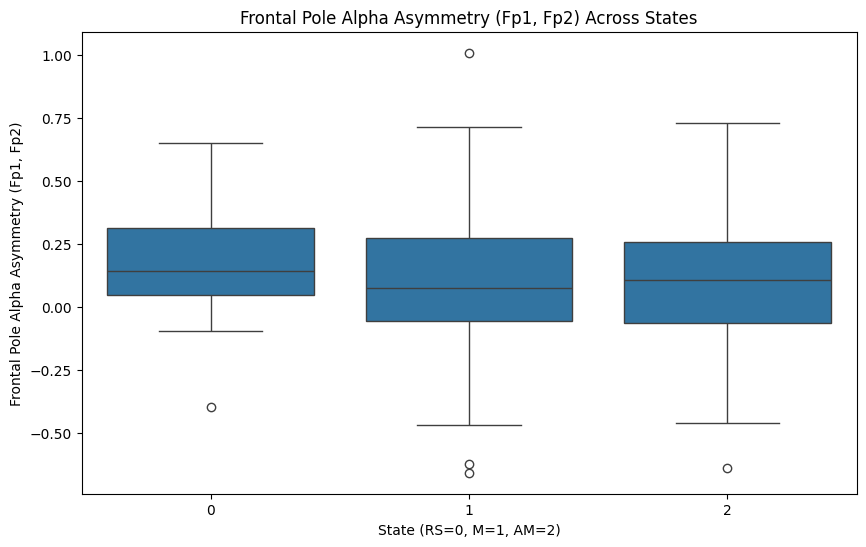

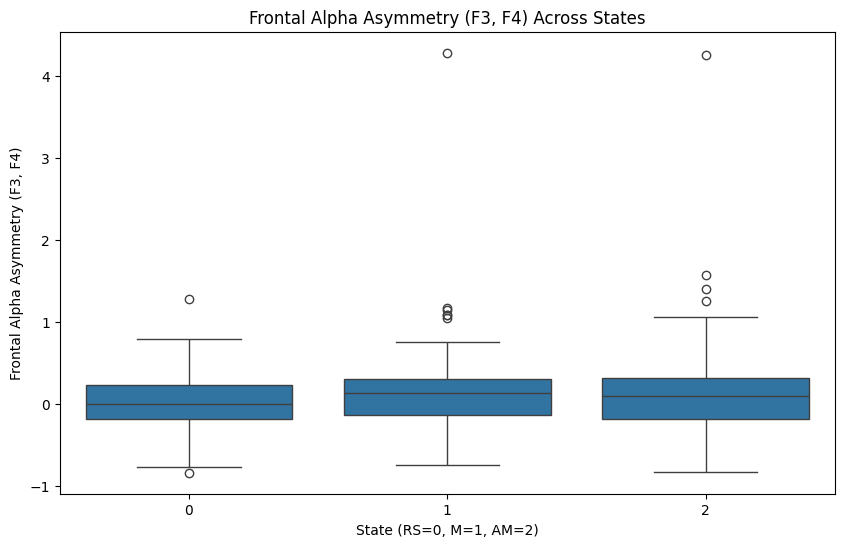

In [17]:
import os
import numpy as np
import scipy.io as sio
from scipy.signal import butter, filtfilt
import pandas as pd

# Path where the EEG data is stored
data_path = r'D:\thesis24\EEG_ANTENATAL_OPD\mat_eeg_final\bp_eeg\aftr_amp'

# Sampling frequency (Hz)
fs = 128

# Define frontal electrodes based on the coordinates provided
frontal_left_fp = 3  # Fp1 is at index 3
frontal_right_fp = 31 # Fp2 is at index 31 (not 32)
frontal_left_f = 5    # F3 is at index 5
frontal_right_f = 30  # F4 is at index 30

# Function to bandpass filter the signal in the alpha band (8-12 Hz)
def bandpass_filter(data, lowcut=8.0, highcut=12.0, fs=128, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Function to compute alpha power from filtered signal
def compute_alpha_power(data):
    return np.mean(np.square(data))

# Prepare to store the results
results = []

# Loop through each subject and file
for file_name in os.listdir(data_path):
    if file_name.endswith('.mat'):
        # Extract label (RS = 0, M = 1, AM = 2) from the file name
        if '_RS_' in file_name:
            label = 0  # Resting State
        elif '_M_' in file_name and '_AM_' not in file_name:
            label = 1  # Listening to OM
        elif '_AM_' in file_name:
            label = 2  # After OM Meditation
        else:
            continue

        # Load the EEG data
        mat_data = sio.loadmat(os.path.join(data_path, file_name))
        data = mat_data['data']  # Assuming the variable is named 'data'

        # Extract frontal channels (Fp1, Fp2, F3, F4)
        fp1_data = data[frontal_left_fp, :]
        fp2_data = data[frontal_right_fp, :]
        f3_data = data[frontal_left_f, :]
        f4_data = data[frontal_right_f, :]

        # Filter the data to get alpha band (8-12 Hz)
        fp1_alpha = bandpass_filter(fp1_data)
        fp2_alpha = bandpass_filter(fp2_data)
        f3_alpha = bandpass_filter(f3_data)
        f4_alpha = bandpass_filter(f4_data)

        # Compute alpha power for left and right frontal regions
        fp1_alpha_power = compute_alpha_power(fp1_alpha)
        fp2_alpha_power = compute_alpha_power(fp2_alpha)
        f3_alpha_power = compute_alpha_power(f3_alpha)
        f4_alpha_power = compute_alpha_power(f4_alpha)

        # Compute Frontal Alpha Asymmetry (FAA = log(Right Alpha Power) - log(Left Alpha Power))
        fp_fa_asymmetry = np.log(fp2_alpha_power) - np.log(fp1_alpha_power)  # For frontal poles (Fp1, Fp2)
        f_fa_asymmetry = np.log(f4_alpha_power) - np.log(f3_alpha_power)     # For frontal electrodes (F3, F4)

        # Store the result (Subject, Trial, Label, FAA)
        subject = file_name.split('_')[0]
        trial = file_name.split('_')[2]
        results.append([subject, trial, label, fp_fa_asymmetry, f_fa_asymmetry])

# Convert results into a DataFrame for analysis
df_results = pd.DataFrame(results, columns=['Subject', 'Trial', 'State', 'Fp_FAA', 'F_FAA'])

# Save the results to a CSV file
df_results.to_csv('frontal_alpha_asymmetry_results.csv', index=False)

# Visualizing FAA across states
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='State', y='Fp_FAA', data=df_results)
plt.title('Frontal Pole Alpha Asymmetry (Fp1, Fp2) Across States')
plt.xlabel('State (RS=0, M=1, AM=2)')
plt.ylabel('Frontal Pole Alpha Asymmetry (Fp1, Fp2)')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='State', y='F_FAA', data=df_results)
plt.title('Frontal Alpha Asymmetry (F3, F4) Across States')
plt.xlabel('State (RS=0, M=1, AM=2)')
plt.ylabel('Frontal Alpha Asymmetry (F3, F4)')
plt.show()
